# RETAIL SALES TIME SERIES ANALYSIS
# Task 7: Time Series Breakdown of Retail Sales

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
# Plot style (simple and readable)
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.grid'] = True
sns.set_style("whitegrid")

# Loading dataset

In [6]:
file_path = r"C:\Users\j\Desktop\Elevvo Internship Program\Tasks\Task 7 Time Series Breakdown of Retail Sales\data\walmart_sales.csv"
df = pd.read_csv(file_path)

In [7]:
print("Rows, Columns:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all').T)

Rows, Columns: (421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Store,421570.0,NaN,NaN,NaN,22.200546,12.785297,1.0,11.0,22.0,33.0,45.0
Dept,421570.0,NaN,NaN,NaN,44.260317,30.492054,1.0,18.0,37.0,74.0,99.0
Date,421570,143,2011-12-23,3027,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Weekly_Sales,421570.0,NaN,NaN,NaN,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36
IsHoliday,421570,2,False,391909,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Convert/ensure types
df['Date'] = pd.to_datetime(df['Date'])
df['Store'] = df['Store'].astype(int)
df['Dept'] = df['Dept'].astype(int)
df['Weekly_Sales'] = pd.to_numeric(df['Weekly_Sales'], errors='coerce')  # safe coercion

# IsHoliday is already bool in your sample; ensure boolean
df['IsHoliday'] = df['IsHoliday'].astype(bool)

In [9]:
# Quick checks
print("Date range:", df['Date'].min().date(), "to", df['Date'].max().date())
print("Unique stores:", df['Store'].nunique(), "Unique depts:", df['Dept'].nunique())
print("Missing values per column:\n", df.isna().sum())
print("Negative Weekly_Sales count (possible returns):", (df['Weekly_Sales'] < 0).sum())


Date range: 2010-02-05 to 2012-10-26
Unique stores: 45 Unique depts: 81
Missing values per column:
 Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64
Negative Weekly_Sales count (possible returns): 1285


Basic descriptive statistics & holiday impact

In [10]:
display(df['Weekly_Sales'].describe().to_frame().T)

,count,mean,std,min,25%,50%,75%,max
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36


In [11]:
display(df.nlargest(5, 'Weekly_Sales'))

,Store,Dept,Date,Weekly_Sales,IsHoliday
95373,10,72,2010-11-26,693099.36,True
338013,35,72,2011-11-25,649770.18,True
95425,10,72,2011-11-25,630999.19,True
337961,35,72,2010-11-26,627962.93,True
135665,14,72,2010-11-26,474330.10,True


In [12]:
# Compare average sales on holiday vs non-holiday weeks
holiday_summary = df.groupby('IsHoliday')['Weekly_Sales'].agg(['count','mean','median']).reset_index()
display(holiday_summary)

,IsHoliday,count,mean,median
0,False,391909,15901.445069,7589.95
1,True,29661,17035.823187,7947.74


# Aggregate to monthly revenue (total across all stores & depts)

In [13]:
# We'll create a DataFrame monthly_total with Year and Month columns for further analysis.
df_ts = df.set_index('Date')
monthly_total = df_ts['Weekly_Sales'].resample('M').sum().to_frame(name='Monthly_Revenue')
monthly_total['Year'] = monthly_total.index.year
monthly_total['Month'] = monthly_total.index.month
display(monthly_total.head(12))

,Monthly_Revenue,Year,Month
Date,,,
2010-02-28,1.903330e+08,2010,2
2010-03-31,1.819198e+08,2010,3
2010-04-30,2.314124e+08,2010,4
2010-05-31,1.867109e+08,2010,5
2010-06-30,1.922462e+08,2010,6
2010-07-31,2.325801e+08,2010,7
2010-08-31,1.876401e+08,2010,8
2010-09-30,1.772679e+08,2010,9
2010-10-31,2.171618e+08,2010,10


# Plot of the monthly revenue series

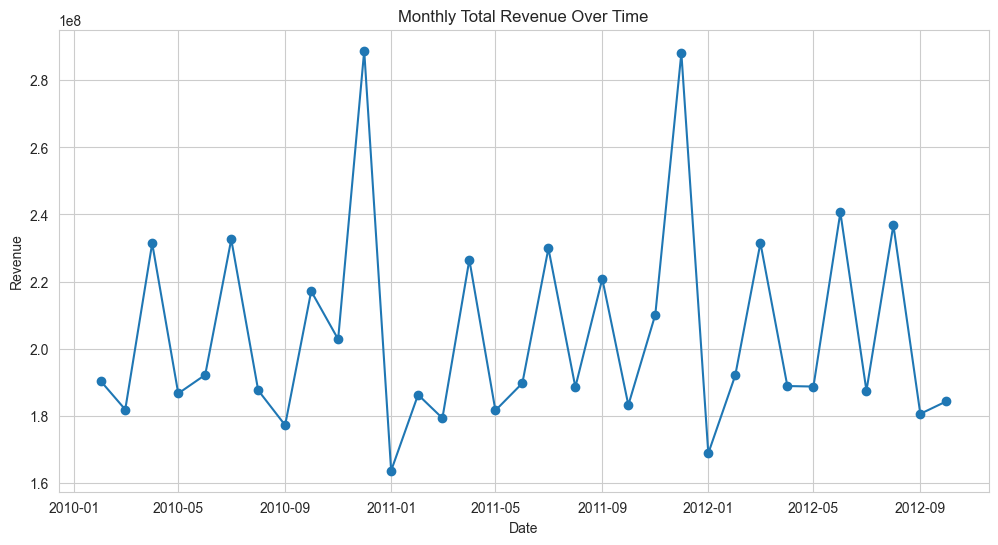

In [14]:
# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract Year-Month only (to avoid daily noise)
df['YearMonth'] = df['Date'].dt.to_period('M')

# Group by Year-Month
monthly_revenue = df.groupby('YearMonth')['Weekly_Sales'].sum()

# Convert to proper datetime index
monthly_revenue.index = monthly_revenue.index.to_timestamp()

# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_revenue.index, monthly_revenue.values, marker='o')
plt.title('Monthly Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

# Moving Average (trend smoothing)

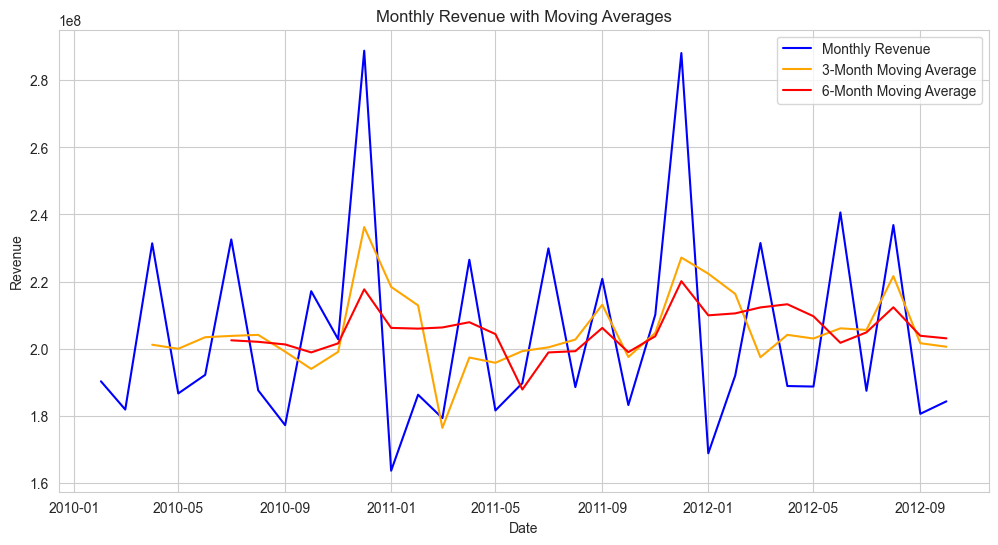

In [15]:
# 3-month moving average
ma3 = monthly_revenue.rolling(window=3).mean()

# 6-month moving average
ma6 = monthly_revenue.rolling(window=6).mean()

plt.figure(figsize=(12,6))
plt.plot(monthly_revenue.index, monthly_revenue.values, label='Monthly Revenue', color='blue')
plt.plot(ma3.index, ma3.values, label='3-Month Moving Average', color='orange')
plt.plot(ma6.index, ma6.values, label='6-Month Moving Average', color='red')
plt.title('Monthly Revenue with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

# Seasonal Patterns

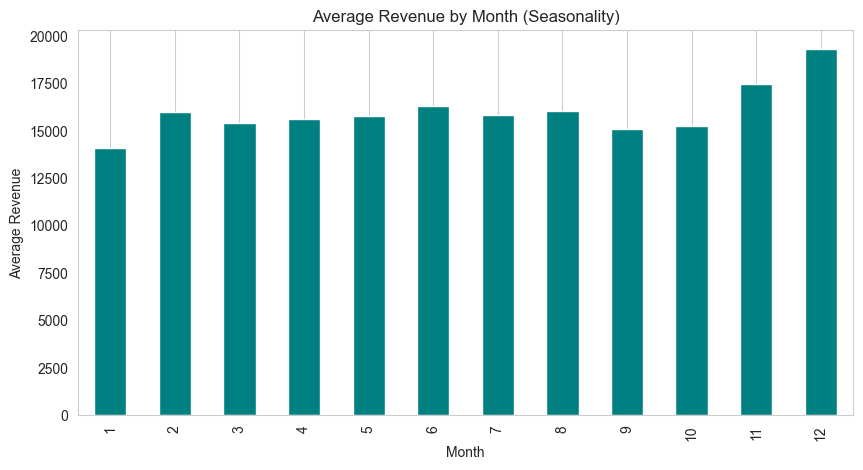

In [16]:
# Extract year and month
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Average monthly sales across all years
monthly_pattern = df.groupby('Month')['Weekly_Sales'].mean()

plt.figure(figsize=(10,5))
monthly_pattern.plot(kind='bar', color='teal')
plt.title('Average Revenue by Month (Seasonality)')
plt.xlabel('Month')
plt.ylabel('Average Revenue')
plt.grid(axis='y')
plt.show()

# Revenue by Region (Store-level)

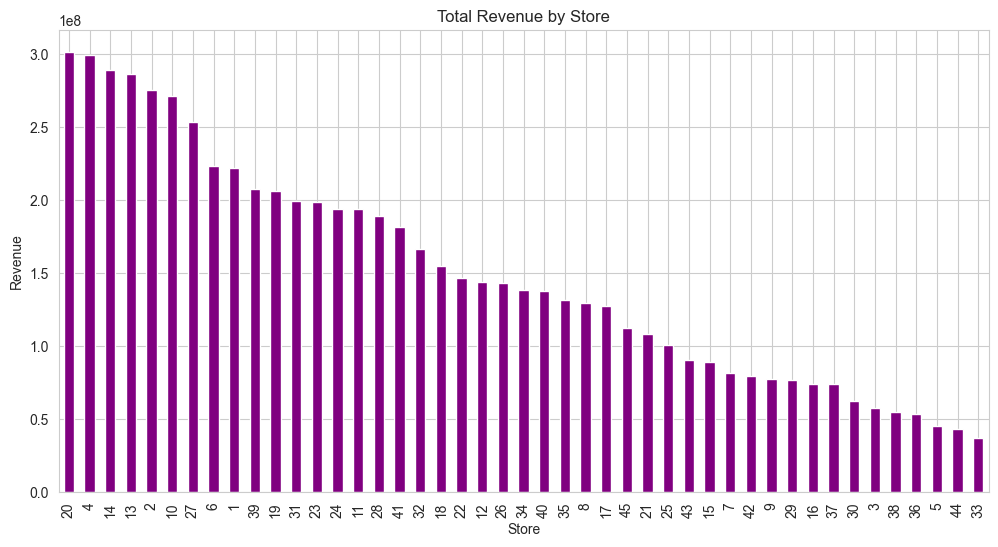

In [17]:
store_revenue = df.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(12,6))
store_revenue.plot(kind='bar', color='purple')
plt.title('Total Revenue by Store')
plt.xlabel('Store')
plt.ylabel('Revenue')
plt.show()

# Revenue by Product (Department-level)

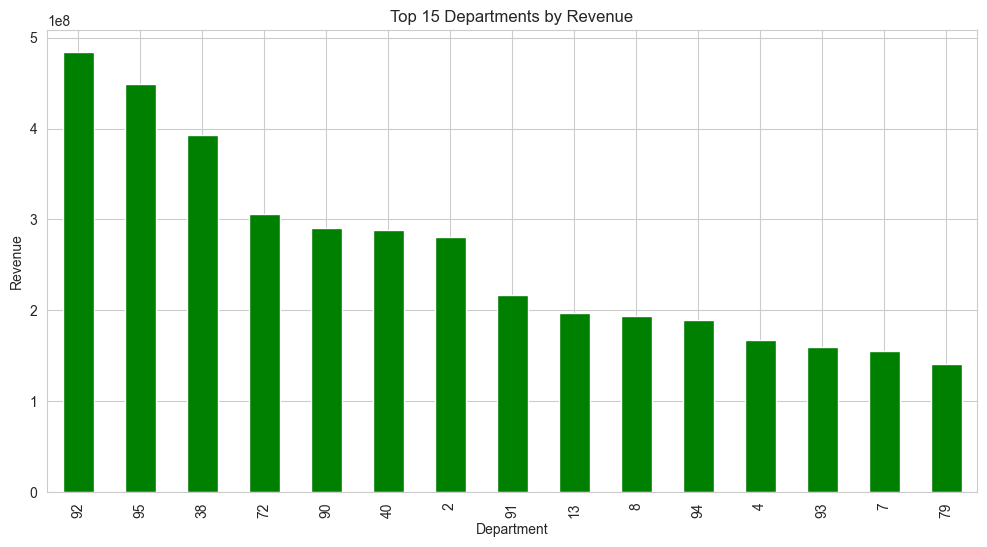

In [18]:
dept_revenue = df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False).head(15)

plt.figure(figsize=(12,6))
dept_revenue.plot(kind='bar', color='green')
plt.title('Top 15 Departments by Revenue')
plt.xlabel('Department')
plt.ylabel('Revenue')
plt.show()

# Simple Forecast (Naïve + Exponential Smoothing)

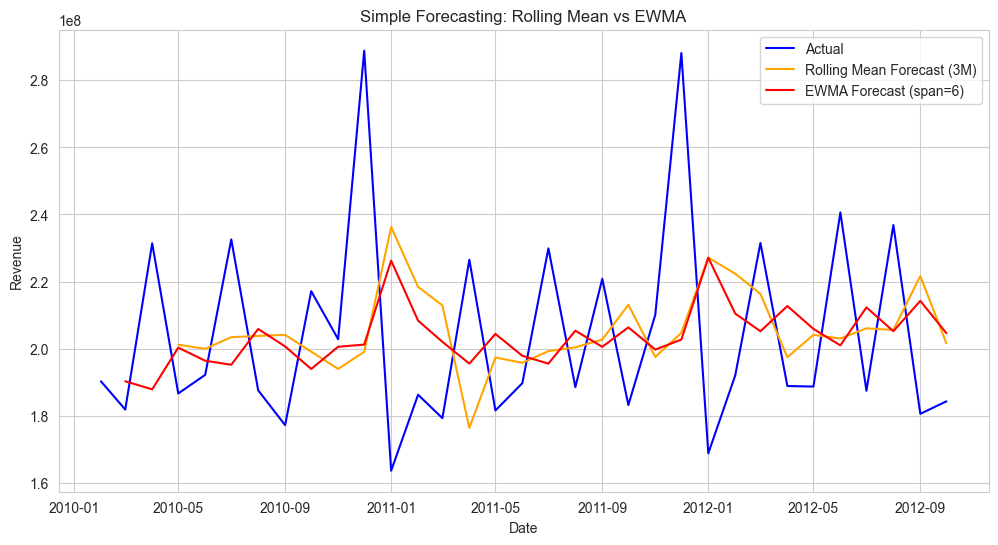

In [23]:
# Rolling Mean Forecast (last 3 months average)
rolling_forecast = monthly_revenue.rolling(window=3).mean().shift(1)

# Exponential Weighted Moving Average (smoother forecast)
ewma_forecast = monthly_revenue.ewm(span=6, adjust=False).mean().shift(1)

plt.figure(figsize=(12,6))
plt.plot(monthly_revenue.index, monthly_revenue.values, label='Actual', color='blue')
plt.plot(rolling_forecast.index, rolling_forecast.values, label='Rolling Mean Forecast (3M)', color='orange')
plt.plot(ewma_forecast.index, ewma_forecast.values, label='EWMA Forecast (span=6)', color='red')
plt.title('Simple Forecasting: Rolling Mean vs EWMA')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()

# Insights Summary

In [24]:
print(f"Dataset covers period: {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"Number of stores: {df['Store'].nunique()}")
print(f"Number of departments: {df['Dept'].nunique()}")

Dataset covers period: 2010-02-05 → 2012-10-26
Number of stores: 45
Number of departments: 81


- Overall sales exhibit clear fluctuations, with pronounced seasonal peaks during November and December, corresponding to holiday shopping periods.

- Moving averages highlight an upward trend in sales until mid-2012, followed by signs of a slowdown.

- Seasonal analysis confirms that November and December consistently outperform other months, reinforcing the strong holiday effect.

- Revenue distribution across stores is highly imbalanced, with a few top-performing stores contributing disproportionately to total sales.

- At the department level, essential categories (e.g., food, household goods) dominate revenue generation, indicating stable consumer demand.


# Managerial Recommendations

- Seasonal Strategy:

Increase inventory levels and marketing campaigns ahead of November–December to fully capture holiday demand.

Prepare holiday promotions and ensure supply chains are resilient during peak months.

- Store-Level Optimisation:

Focus on top-performing stores with targeted investments (staffing, logistics, promotions).

Identify underperforming stores and investigate causes (location, competition, product mix) to improve efficiency.

- Department-Level Strategy:

Prioritise essential departments (food, household) since they provide steady revenue.

Explore cross-selling opportunities by bundling low-performing departments with high-demand items.

- Revenue Diversification:

Reduce reliance on holiday-driven peaks by promoting off-season campaigns (spring/summer sales).

Launch loyalty programmes to stabilise sales outside of peak periods.
